In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json

from scipy.spatial.distance import pdist, squareform

Text(0.5, 1.0, 'Population of North Carl, N=1000')

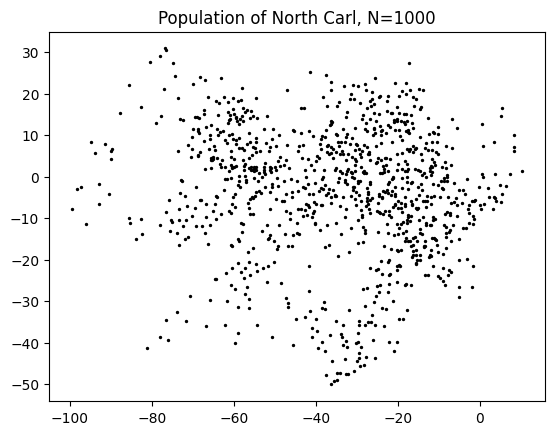

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [3]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost

In [4]:
# triangular lattice

def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points

In [5]:

# Example usage:
R_antennas = 25
spacing = R_antennas*1.5 #this is arbitrary - you can try bigger and smaller grids!
offset = (x.min(), y.min())
side_lengths = (int(np.ceil((x.max() - x.min())/spacing)), int(np.ceil((y.max() - y.min())/spacing)))

grid_points = generate_triangular_grid(side_lengths = side_lengths, spacing = spacing, offset = offset) 

Text(0.5, 1.0, 'Population of North Carl, N=1000')

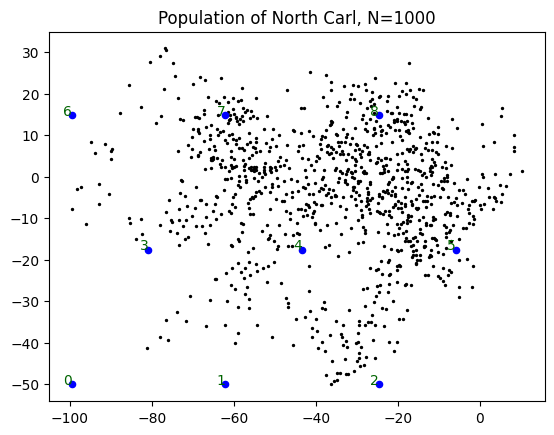

In [6]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
x1 = np.array(grid_points)[:,0]
y1 = np.array(grid_points)[:,1]
plt.scatter(x, y, s=2, facecolor='black')
plt.scatter(x1, y1, s=20, facecolor='blue')
for i, (w, z) in enumerate(zip(x1, y1)):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')

plt.title('Population of {}, N={}'.format(city_name, len(x)))

## Generating Graph corresponding to Antenna Placements


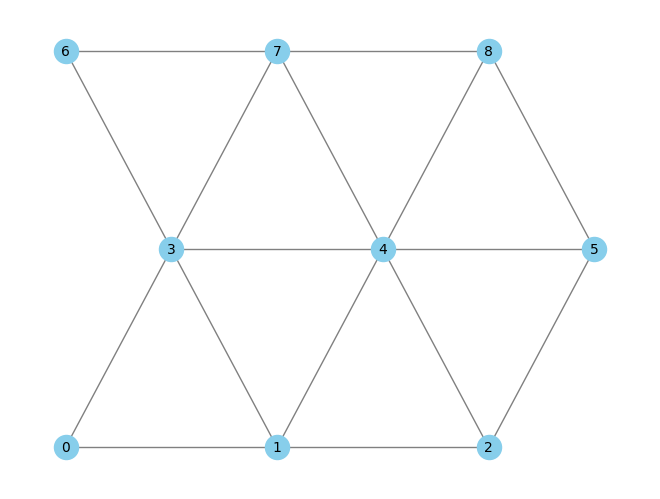

In [7]:

import networkx as nx

pairwise_dist = pdist(np.array(grid_points))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(grid_points):
    G.add_node(i, pos=(x, y))

# Add edges based on distance threshold
threshold = 50
for i in range(len(grid_points)):
    for j in range(i + 1, len(grid_points)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)

G

In [8]:
adj_mtrx = nx.adjacency_matrix(G)
adj_mtrx.todense()

array([[0, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 0]], dtype=int32)

QUBO formulation of the MIS problem:

$$min(-\sum_{i}x_{i}+\alpha\sum_{i<j}x_{i}x_{j})$$ 

where $\alpha>1$. Let's take alpha = 100.

In [9]:
# Constructing QUBO Matrix

diagonal_elements = -1*np.eye(adj_mtrx.shape[0])
print('diagonal_elements',diagonal_elements)

alpha = 100
offdiagonal_elements = alpha*adj_mtrx.todense()
print('offdiagonal_elements', offdiagonal_elements)

diagonal_elements [[-1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -1.]]
offdiagonal_elements [[  0 100   0 100   0   0   0   0   0]
 [100   0 100 100 100   0   0   0   0]
 [  0 100   0   0 100 100   0   0   0]
 [100 100   0   0 100   0 100 100   0]
 [  0 100 100 100   0 100   0 100 100]
 [  0   0 100   0 100   0   0   0 100]
 [  0   0   0 100   0   0   0 100   0]
 [  0   0   0 100 100   0 100   0 100]
 [  0   0   0   0 100 100   0 100   0]]


In [10]:
qubo = diagonal_elements+offdiagonal_elements
print(qubo)

[[ -1. 100.   0. 100.   0.   0.   0.   0.   0.]
 [100.  -1. 100. 100. 100.   0.   0.   0.   0.]
 [  0. 100.  -1.   0. 100. 100.   0.   0.   0.]
 [100. 100.   0.  -1. 100.   0. 100. 100.   0.]
 [  0. 100. 100. 100.  -1. 100.   0. 100. 100.]
 [  0.   0. 100.   0. 100.  -1.   0.   0. 100.]
 [  0.   0.   0. 100.   0.   0.  -1. 100.   0.]
 [  0.   0.   0. 100. 100.   0. 100.  -1. 100.]
 [  0.   0.   0.   0. 100. 100.   0. 100.  -1.]]


In [11]:
# Defining MIS Cost Function
## Get cost based on Q matix
def get_cost_Q(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

## Get avergae cost
def get_avg_cost(counter, Q):
    cost = sum(counter[key] * get_cost_Q(key, Q) for key in counter)
    return cost / sum(counter.values())


## Solution through NAQC

In [12]:
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig

from scipy.optimize import minimize

In [35]:
pdist(grid_points)

array([37.5       , 75.        , 37.5       , 64.95190528, 99.21567416,
       64.95190528, 75.        , 99.21567416, 37.5       , 37.5       ,
       37.5       , 64.95190528, 75.        , 64.95190528, 75.        ,
       64.95190528, 37.5       , 37.5       , 99.21567416, 75.        ,
       64.95190528, 37.5       , 75.        , 37.5       , 37.5       ,
       64.95190528, 37.5       , 64.95190528, 37.5       , 37.5       ,
       99.21567416, 64.95190528, 37.5       , 37.5       , 75.        ,
       37.5       ])

In [ ]:
# Create a UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
coords *= 4/spacing #why?


In [109]:
device_used = MockDevice
seed = 100

### optimising positions of atoms

In [46]:
# Maps the QUBO to Rydberg Atoms in NAQC
# Calculates the distances between atoms on the hardware and those in the Q matrix.
def mapping(coords, Q):
    coords = np.reshape(coords, (len(Q), 2))
    new_Q = squareform(device_used.interaction_coeff / pdist(coords) ** 6)
    return np.linalg.norm(new_Q - Q)

In [ ]:
# Perform optimization
# Create random initial coordinates
x0 = np.random.random(len(qubo)*2)

# Optimize atom coordinates.
optimal_pos = minimize(
    mapping, 
    x0,
    args=(qubo,),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 20000, "maxfev": None}
)

# Reshape coordinates
coords = np.reshape(optimal_pos.x, (len(qubo), 2))
print(coords) # optimal position of atoms

[[-19.04660699   0.92554168]
 [ 12.84945631   2.20116411]
 [ -2.35264276  -1.43772073]
 [  7.18186528  -0.33515942]
 [ 17.14669329   6.63126489]
 [  1.26443435   3.7717636 ]
 [  5.39756045  10.71743424]
 [  3.26885527  16.45999189]
 [-12.32222268  -3.7395671 ]]


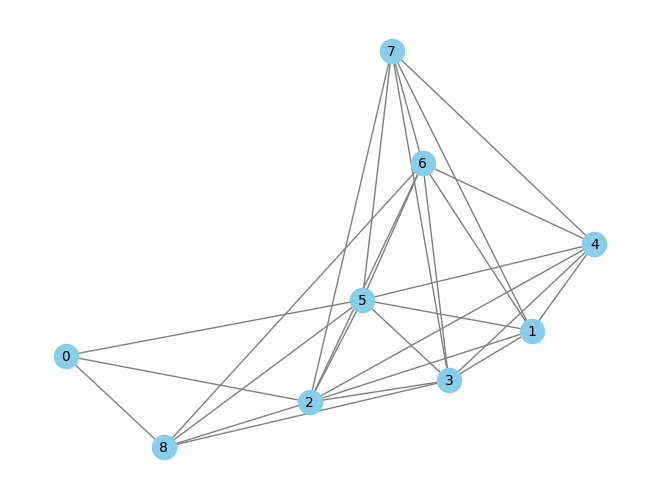

In [60]:
pairwise_dist = pdist(np.array(coords))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(coords):
    G.add_node(i, pos=(x, y))

# Add edges based on distance threshold
threshold = 25
for i in range(len(coords)):
    for j in range(i + 1, len(grid_points)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)

G

In [54]:
new_qubo =  squareform(device_used.interaction_coeff / pdist(coords) ** 6)
print(new_qubo)

# Set Rabi frequency and Detuning
omega_max = np.median(new_qubo[new_qubo>0].flatten()) # why omega_max is taken as median
delta_0 = -5
delta_f = -delta_0

[[0.00000000e+00 5.12279824e-03 2.35940819e-01 1.65335979e-02
  2.24005740e-03 7.28252870e-02 1.62578582e-02 1.34137940e-02
  1.80370369e+01]
 [5.12279824e-03 0.00000000e+00 3.71535251e-01 9.45770831e+01
  9.80639408e+01 2.12276386e+00 2.58104647e+00 2.10909019e-01
  1.81099511e-02]
 [2.35940819e-01 3.71535251e-01 0.00000000e+00 6.93290191e+00
  6.13703247e-02 8.32955601e+01 6.03936228e-01 1.24349917e-01
  4.72371502e+00]
 [1.65335979e-02 9.45770831e+01 6.93290191e+00 0.00000000e+00
  1.67777710e+00 3.88098202e+01 2.75236360e+00 2.06081194e-01
  8.99820023e-02]
 [2.24005740e-03 9.80639408e+01 6.13703247e-02 1.67777710e+00
  0.00000000e+00 3.06884174e-01 1.46289600e+00 2.24091277e-01
  5.83043596e-03]
 [7.28252870e-02 2.12276386e+00 8.32955601e+01 3.88098202e+01
  3.06884174e-01 0.00000000e+00 1.94434040e+01 1.20639729e+00
  3.87139186e-01]
 [1.62578582e-02 2.58104647e+00 6.03936228e-01 2.75236360e+00
  1.46289600e+00 1.94434040e+01 0.00000000e+00 1.02713604e+02
  3.78894132e-02]
 [1.34

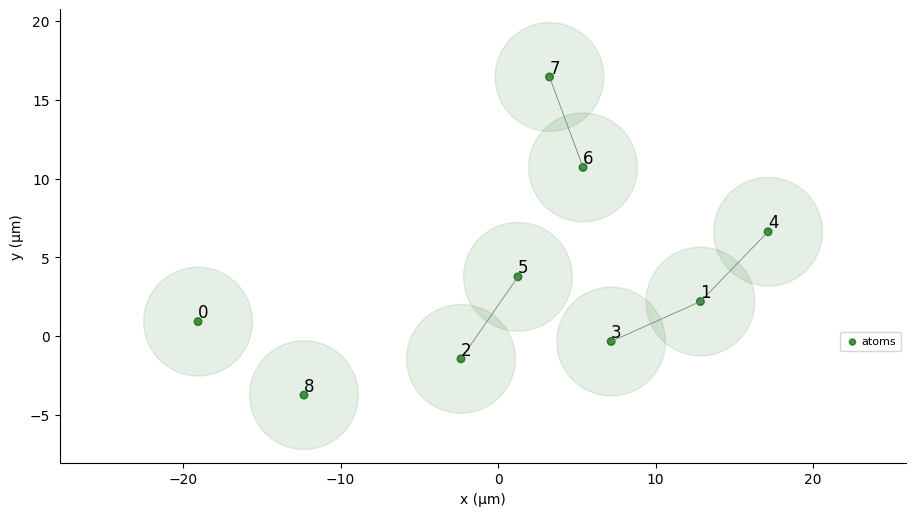

In [62]:
# Create a Register
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(2*R_antennas),
    draw_graph=True,
    draw_half_radius=True
)

### Optimising Pulse

In [110]:

# Interaction coefficient (U_ij or Q)
# U_ij = C_6/r**6
Q = squareform(device_used.interaction_coeff / pdist(coords) ** 6)

# Set Rabi frequency and Detuning
omega_max = np.median(Q[Q>0].flatten()) # why omega_max is taken as median
delta_0 = -5
delta_f = -delta_0

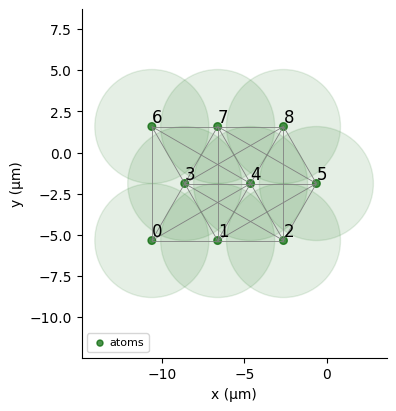

In [111]:
# Cretae a Register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(omega_max),
    draw_graph = True,
    draw_half_radius = True, 
)

In [112]:
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")

# Define variables for sequence of pulses
t_rise = seq.declare_variable("t_rise", size=1) 
t_fall = seq.declare_variable("t_fall", size=1)
t_sweep = seq.declare_variable("t_sweep", size=1)


In [113]:
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0
)

In [114]:
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
#seq.draw()

In [115]:
# Define the pulse params
rabi_time = np.random.uniform(10,20,1)

param_dict = {
    "trise": rabi_time, # min,max and size
    "tfall": rabi_time,
    "tsweep":np.random.uniform(100,200,1)
} 

print(param_dict)

{'trise': array([13.69099407]), 'tfall': array([13.69099407]), 'tsweep': array([154.2412091])}


c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\parametrized\paramobj.py:198: UserWarning: A waveform duration of array([13.69099407]) ns is below the supported precision of 1 ns. It was rounded down to 13 ns.
  self._instance = obj(*args_, **kwargs_)
c:\Users\navan\anaconda3\envs\qc\lib\site-packages\pulser\parametrized\paramobj.py:198: UserWarning: A waveform duration of array([154.2412091]) ns is below the supported precision of 1 ns. It was rounded down to 154 ns.
  self._instance = obj(*args_, **kwargs_)


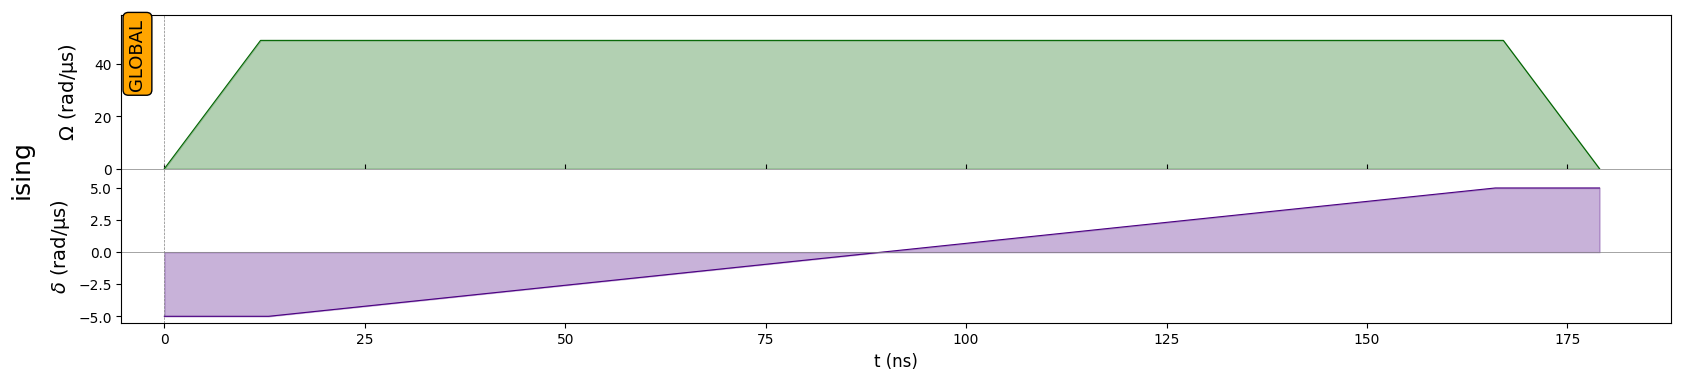

In [116]:
sample_sequence = seq.build(t_rise=param_dict["trise"], t_fall=param_dict['tfall'],t_sweep=param_dict['tsweep'])
sample_sequence.draw()

In [117]:
# Define a quantum loop that runs these sequences
def quantum_loop(params):
    params = np.array(params)
    t_rise, t_fall,t_sweep = np.reshape(params.astype(int), (3,1))

    sample_sequence = seq.build(t_rise=t_rise,t_fall=t_fall,t_sweep=t_sweep)
    simulate = QutipEmulator.from_sequence(sample_sequence, sampling_rate=1) #
    results = simulate.run()

    count_dict = results.sample_final_state(N_samples = 1000)
    return count_dict

In [118]:
# Main function that runs the pulses, obtains samples, and calcualtes the avg cost
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, Q)
    return cost

In [ ]:
scores = []
params = []

for repetition in range(20):
    # Define the pulse params
    a

{'trise': array([468]), 'tfall': array([468]), 'tsweep': array([2094])}
{'trise': array([820]), 'tfall': array([820]), 'tsweep': array([1528])}


KeyboardInterrupt: 

In [121]:
rabi_time = np.random.randint(700,900,1)

param_dict = {
    "trise": rabi_time, # min,max and size
    "tfall": rabi_time,
    "tsweep":np.random.randint(1000,2500,1)
} 

print("initial_guess", param_dict)

try:
    res = minimize(
        func,
        args=qubo,
        x0=np.r_[param_dict["trise"], param_dict["tfall"],param_dict['tsweep']],
        method="Nelder-Mead",
        tol=1e-5,
        options={"maxiter":500},
    )
    scores.append(res.fun)
    params.append(res.x)
except Exception as e:
    pass

initial_guess {'trise': array([798]), 'tfall': array([798]), 'tsweep': array([1750])}


In [123]:
params

[array([ 465.67083333,  468.27083333, 2154.34791667]),
 array([ 792.23486793,  802.24489327, 1757.21582524])]

In [ ]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5)
    plt.xticks(rotation="vertical")
    plt.show()


In [124]:
# Plot distribution
optimal_count_dict = quantum_loop(params[1])
optimal_count_dict['101000101']

0

In [105]:
params[np.argmin(scores)]

array([ 871.06695602,  857.73454861, 1532.02204861])

In [ ]:
ind_set = nx.approximation.maximum_independent_set(G)
print("Heuristic solution: ", ind_set)

nil_string = np.zeros(len(G), dtype=int)
for v in ind_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) # print the output string

Heuristic solution:  {8, 0, 2, 6}
Heuristic bitstring:  101000101
